# SVMs for Activity Recognition

In this lab, you haave to use SVMs for *activity recognition*, i.e. determining the type of activity a person is doing using sensor data like accelerometers in a smartphone.

<table align='left'>
<tr>
<td><img width='550'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/AR_pic.jpg'></td>
<td><img width='400'  align='left' src='http://jricardon.github.io/BBS19lab3Files/figs/wearable_TEG.png'></td>
</tr>
</table>







# Data & Problem Description

You will use a pre-processed dataset produced from real data originally collected by collegues from the University of Genova and the Polytechnic University of Catalonia, named "Activity Recognition Using Smart Phones Dataset". Details regarding the data collection methodology are provided in the following paper:


> Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. *A public domain dataset for human activity recognition using smartphones*. 2013.

The experiments were carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, the reseachers captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The obtained dataset was randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. 


In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/XOEN9W05_4A" frameborder="0" allowfullscreen></iframe>')

C:\Users\Work\Anaconda3\envs\my_env\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


As SVMs cannot directly handle sequential data, the signals corresponding to each the different movements were pre-processed to obtain 563 features than correspond to:

1.   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.

2.   Triaxial Angular velocity from the gyroscope.

3.   A 561-feature vector with time and frequency domain variables.

In addition, the dataset provide:

*   The activity label.
*   An identifier of the subject who carried out the experiment.



## Downloading the Data

You can download the train and test data directly from Kaggle:

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

Remember that only the train set can be used for model design and selection. The test data should be used to evaluate the final model.


## Activities

You should address the following activities and questions:

1.   Explore the dataset to determine the type of data you have, the proportion of missing values, the proportion of examples in each class, the approximate distribution of each feature and the presence of outliers. Do you see variable with extremely skew distributions? Evaluate the convinience of a manual transformation.

2.   Prepare your dataset to train SVMs, considering the presence of categorical variables and the convenience of a scaling. Evaluate the need of a robust scaling instead of standard normalization.

3.   Train a linear SVM, evaluating the impact of regularization on the test performance. Use cross-validation to choose values for the SVM (hyper) parameters. Can these values be chosen according to their performance on the train set? Can these values be chosen according to their performance on the test set?  

4.   Train non-linear SVMs, evaluating the impact of the kernel on the test performance. Include the RBF kernel in your analysis, explaining the theoretical effect of parameter gamma in the result. Contrast the theory with the empirical observations.  

5.  Determine the variables of the dataset to which the linear SVM obtained in 3 gives more weight in the decision function. Are these values proportional to the importance of the attribute?

6. Compare the number of support vectors in the linear and non-linear models from activities 3 and 4. Mention a practical consequence of a large support set.

7. Choose, explain and compare two different strategies to handle multiple classes (perhaps you did not notice, but in the activities 3 and 4 your classifier selected an heuristic to extend the SVM to multiple categories).

8. Evaluate the performance of linear and non-linear SVMs on each class, measuring accuracy, precision and recall. Explain the difference between the different metrics.

9. Evaluate the need of class balancing to increase the performance on the categories with the worst results.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statistics
from heapq import nlargest
from heapq import nsmallest
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
train_data_url = "train.csv"
test_data_url = "test.csv"

train_df = pd.read_csv(train_data_url)
test_df = pd.read_csv(test_data_url)

target_name = 'Activity'

## Data Shape

In [4]:
print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}'.format(test_df.shape))

Shape Train:	(7352, 563)
Shape Test:	(2947, 563)


## 1. Data  Exploration

### Type of Data

In [5]:
print("\nBasic Info of Each Variable\n")
print(train_df.info())
print(test_df.info())


Basic Info of Each Variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB
None


### Proportion of Missing Values

In [6]:
print("Total number of missing values in Train set:", train_df.isna().values.sum())
print("Total number of missing values in Test set:", test_df.isna().values.sum())

Total number of missing values in Train set: 0
Total number of missing values in Test set: 0


### Proportion of Example in Each Class

In [7]:
train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


### Approximate Distribution of Each Feature

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64 

LAYING                19.135047
STANDING              18.686251
SITTING               17.489460
WALKING               16.673467
WALKING_UPSTAIRS      14.592683
WALKING_DOWNSTAIRS    13.409493
Name: Activity, dtype: float64


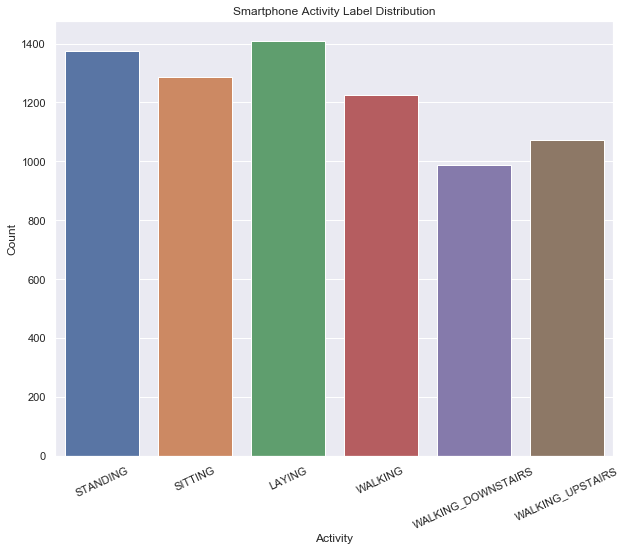

In [8]:
print(train_df[target_name].value_counts(),"\n")

activity_distribution = (train_df[target_name].value_counts() / (train_df[target_name].count() + 1) ) * 100
print(activity_distribution)

plt.figure(figsize=(10,8))
sns.countplot(train_df[target_name])
plt.title('Smartphone Activity Label Distribution')
plt.ylabel('Count')
plt.xlabel('Activity')
plt.xticks(rotation=25)
plt.show()

### Presence of Outliers

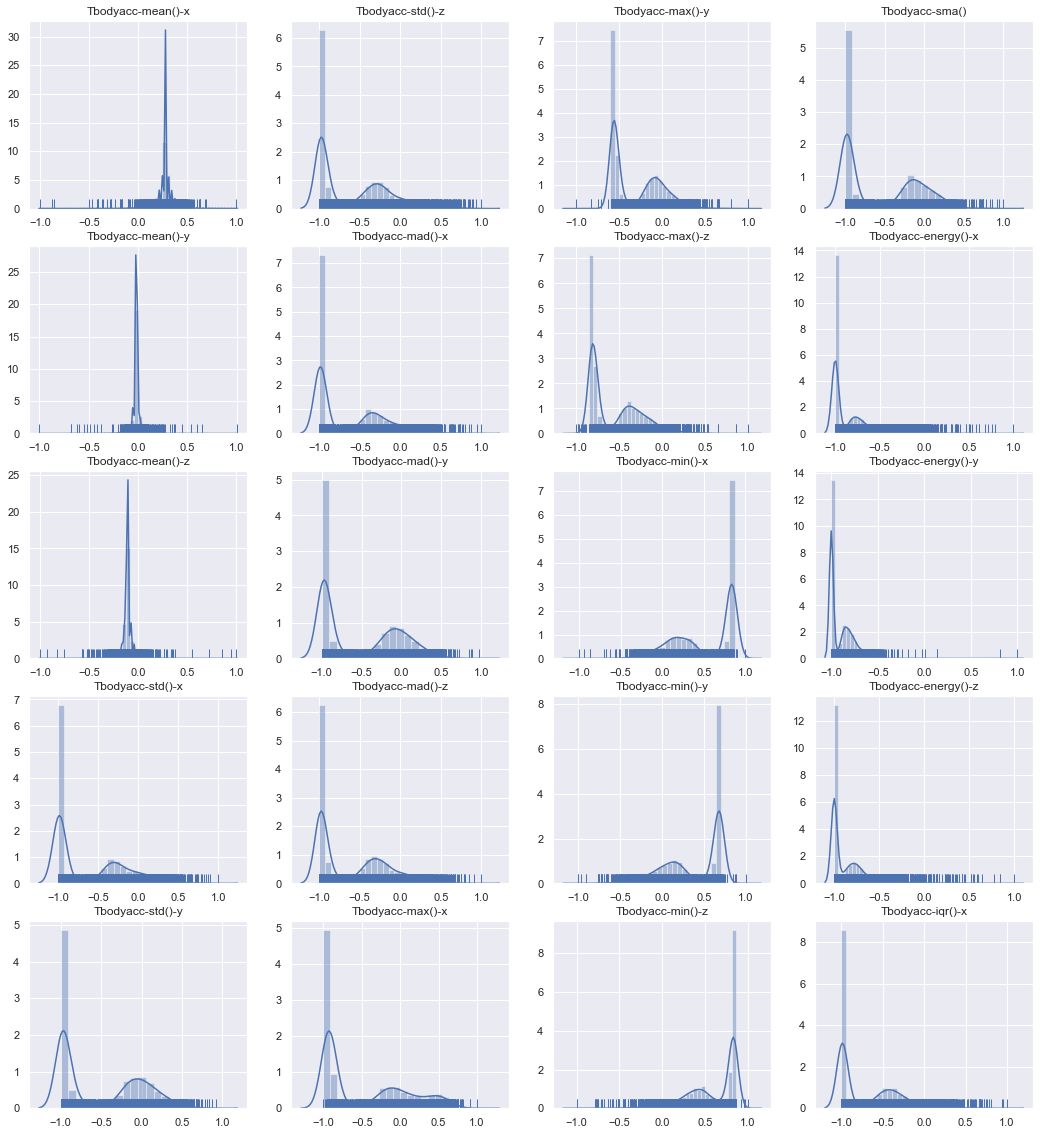

In [9]:
try:
    fig, ax = plt.subplots(figsize=(18,20), nrows=5, ncols=4)
    counter = 0
    for column in train_df.columns:
      j = counter//5; i = counter%5;
      sns.distplot(train_df[column].values,ax=ax[i,j],rug=True)
      ax[i,j].set_title(column.capitalize())
      counter += 1
    plt.subplots_adjust(hspace=0.5)
    plt.show()
except Exception:
    pass

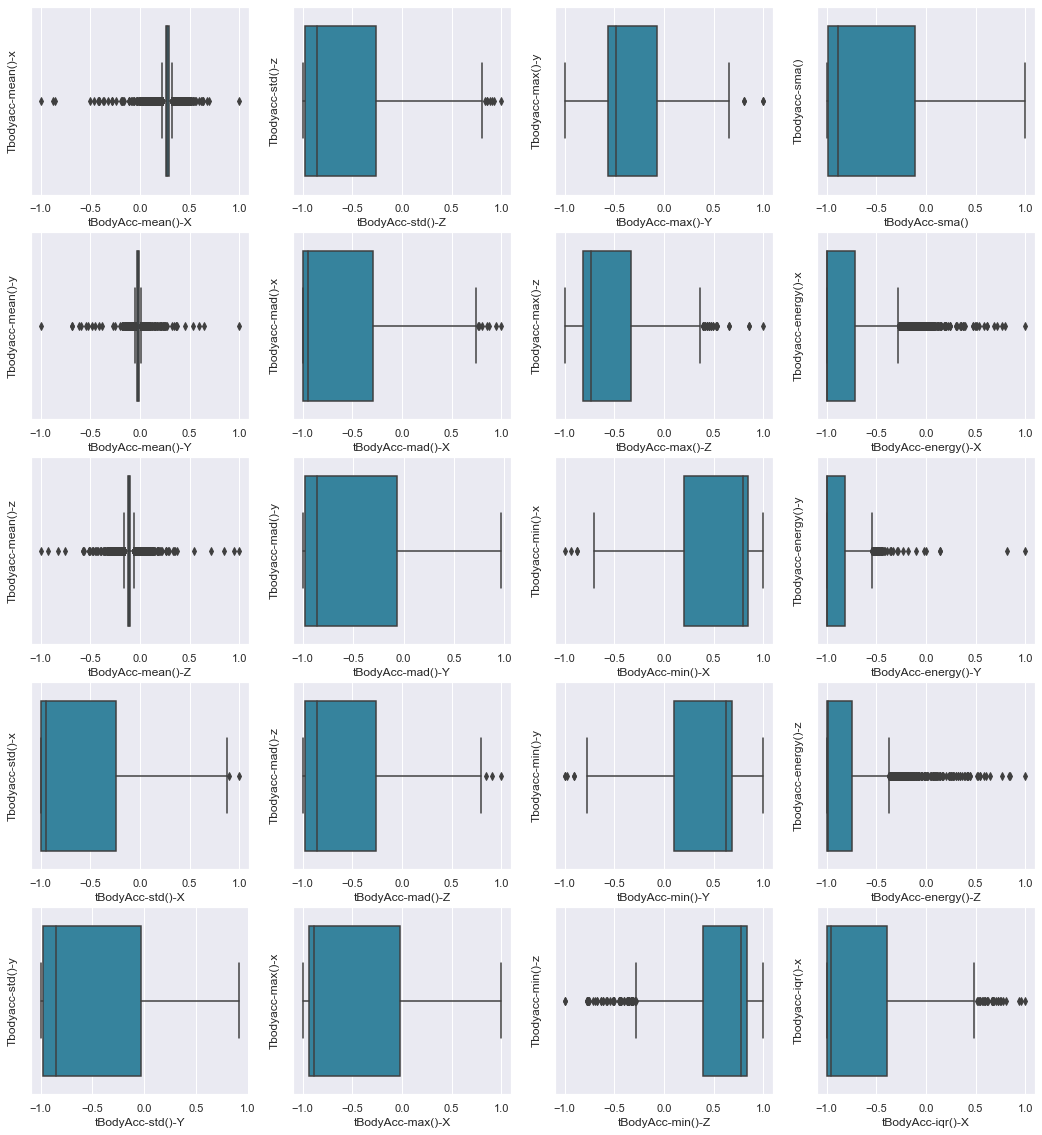

In [10]:
try:
    fig, ax = plt.subplots(figsize=(18,20), nrows=5, ncols=4)
    counter = 0
    for column in train_df.columns:
      j = counter//5; i = counter%5;
      sns.boxplot(x = column, data = train_df,ax=ax[i,j],palette="PuBuGn_d")
      ax[i,j].set_ylabel(column.capitalize()) # Y label
      counter +=1
    plt.tight_layout()
    plt.show()
except Exception:
    pass

### Correlations

In [11]:
correlations = train_df.corr()
correlations = correlations.unstack()
correlations = correlations[correlations < 1]
correlations = correlations[correlations > -1]

print(correlations.nlargest(20),"\n")
print(correlations.nsmallest(20))

tBodyAccJerk-energy()-Z         fBodyAccJerk-energy()-Z           1.000000
fBodyAccJerk-energy()-Z         tBodyAccJerk-energy()-Z           1.000000
tBodyAccJerk-energy()-Y         fBodyAccJerk-energy()-Y           1.000000
fBodyAccJerk-energy()-Y         tBodyAccJerk-energy()-Y           1.000000
tBodyAccJerk-energy()-X         fBodyAccJerk-energy()-X           0.999999
fBodyAccJerk-energy()-X         tBodyAccJerk-energy()-X           0.999999
fBodyAcc-energy()-X             fBodyAcc-bandsEnergy()-1,24       0.999878
fBodyAcc-bandsEnergy()-1,24     fBodyAcc-energy()-X               0.999878
fBodyGyro-energy()-X            fBodyGyro-bandsEnergy()-1,24      0.999767
fBodyGyro-bandsEnergy()-1,24    fBodyGyro-energy()-X              0.999767
fBodyAcc-energy()-Y             fBodyAcc-bandsEnergy()-1,24.1     0.999661
fBodyAcc-bandsEnergy()-1,24.1   fBodyAcc-energy()-Y               0.999661
tBodyAccJerk-sma()              tBodyAccJerkMag-mean()            0.999656
                         

### Skew Distributions

In [12]:
from scipy.stats import skew
from heapq import nlargest
from heapq import nsmallest

train_var = train_df.drop([target_name, 'subject'], axis = 1)
train_skew_val = skew(train_var, axis = 0, bias = True) # Most values really skewed
columns = train_df.columns.drop([target_name, 'subject'])
train_skew = dict(zip(columns, train_skew_val))

print("Mean\t:",statistics.mean(train_skew_val))
print("Median\t:",statistics.median(train_skew_val))

Mean	: 1.6669734445878825
Median	: 0.9079772071388302


#### Largest 20 Skewness

In [13]:
largest = nlargest(20, train_skew, key = train_skew.get)

for val in largest:
    print(val, '\t:', train_skew.get(val)) # Some variables have extreme positive skewness

fBodyAccJerk-bandsEnergy()-57,64 	: 14.703051424607455
fBodyGyro-bandsEnergy()-33,40.1 	: 12.339695999182329
tGravityAcc-iqr()-X 	: 12.187251835995703
tGravityAcc-mad()-X 	: 11.053256142219153
tGravityAcc-std()-X 	: 10.703337261551154
fBodyGyro-bandsEnergy()-33,48.1 	: 10.311948825622128
fBodyGyro-bandsEnergy()-33,40.2 	: 9.86901751074003
tGravityAcc-iqr()-Y 	: 9.687268971100295
tGravityAcc-mad()-Y 	: 9.123496380899786
fBodyGyro-bandsEnergy()-33,48.2 	: 9.02708878861723
tGravityAcc-std()-Y 	: 8.956673099446608
fBodyAccJerk-bandsEnergy()-57,64.1 	: 8.816136597950365
fBodyGyro-bandsEnergy()-25,48.2 	: 8.511524422421708
fBodyGyro-bandsEnergy()-57,64 	: 8.454790239375194
fBodyAccJerk-bandsEnergy()-57,64.2 	: 8.098432567146222
fBodyGyro-bandsEnergy()-25,32.2 	: 8.079690170831517
fBodyGyro-bandsEnergy()-57,64.1 	: 8.054259643609848
fBodyGyro-bandsEnergy()-57,64.2 	: 7.930243348666203
fBodyGyro-bandsEnergy()-25,48.1 	: 7.850385940473805
fBodyAccJerk-bandsEnergy()-33,40.2 	: 7.75201421655062


#### Smallest 20 Skewness

In [14]:
smallest = nsmallest(20, train_skew, key = train_skew.get)
for val in smallest:
    print(val, '\t:', train_skew.get(val)) # Negative skewness much more limited

tBodyAcc-mean()-X 	: -3.447618906556668
tBodyGyroJerk-min()-Y 	: -2.0608069776582045
tGravityAcc-max()-X 	: -1.622867730289325
tGravityAcc-mean()-X 	: -1.6114341382497015
tGravityAcc-min()-X 	: -1.6095204613707959
tBodyGyroJerk-min()-Z 	: -1.5514257450982565
angle(Y,gravityMean) 	: -1.501182848129192
tGravityAcc-energy()-X 	: -1.395574607598805
tBodyGyro-min()-Y 	: -1.3873613590200509
tBodyGyro-min()-X 	: -1.2810675873377486
tBodyGyroJerk-min()-X 	: -1.2173750107772272
tBodyAcc-min()-Z 	: -1.1577450300316887
tBodyAccJerk-min()-Z 	: -1.1547937726024409
tBodyGyro-min()-Z 	: -0.9019519105292038
angle(Z,gravityMean) 	: -0.8697207430820107
tBodyAccJerk-min()-Y 	: -0.8432656150091116
tBodyAccJerk-min()-X 	: -0.7381065172177554
tBodyAcc-min()-Y 	: -0.7256550135239196
tBodyAcc-min()-X 	: -0.6049489765109078
tGravityAcc-arCoeff()-X,4 	: -0.5881525721985682


**Comment:**
- There are a lot of outliers in first 20 variables.
- With total of 560 variables, manual outlier removal will be costly.
- Possibly using robust scaler to remove the outliers on scaling part.

## 2. Train SVMs

### Preparing Data

#### Scaling

In [15]:
# Seperating Predictors and Outcome values from Train and Test sets
X_train = train_df.drop([target_name], axis = 1)
Y_train = train_df[target_name]
X_test = test_df.drop([target_name], axis = 1)
Y_test = test_df[target_name]
columns = X_train.columns

# Standard Scaling The Train and Test Feature Set
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_mean = True, with_std = True)
X_train_s_scaled = s_scaler.fit_transform(X_train)
X_test_s_scaled = s_scaler.transform(X_test)
X_train_s_scaled = pd.DataFrame(X_train_s_scaled, columns = columns)
X_test_s_scaled = pd.DataFrame(X_test_s_scaled, columns = columns)

# Robust Scaling The Train and Test Feature Set
from sklearn.preprocessing import RobustScaler
r_scaler = RobustScaler()
X_train_r_scaled = r_scaler.fit_transform(X_train)
X_test_r_scaled = r_scaler.transform(X_test)
X_train_r_scaled = pd.DataFrame(X_train_r_scaled, columns = columns)
X_test_r_scaled = pd.DataFrame(X_test_r_scaled, columns = columns)

#### Standard Scaling

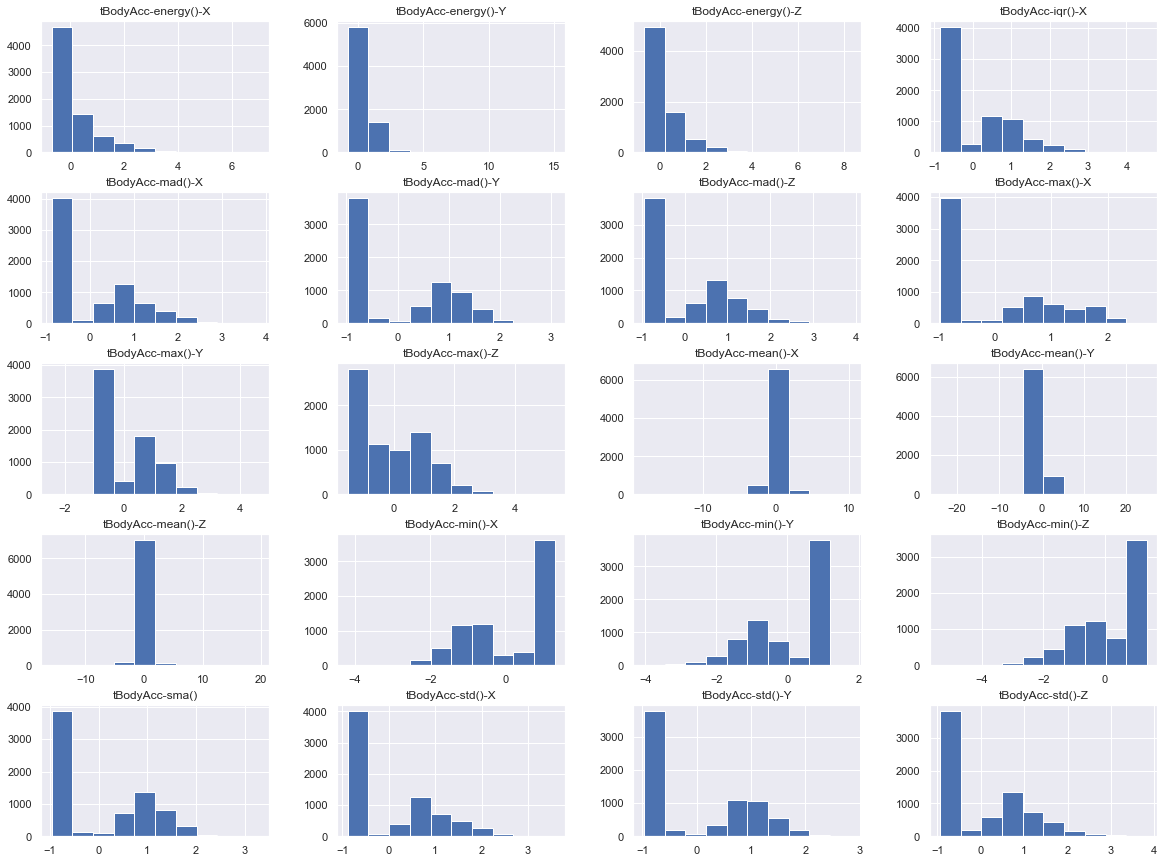

In [16]:
X_train_s_scaled.iloc[:,:20].hist(figsize=(20,15))#make a histogram of each variable
plt.plot();

#### Robust Scaling

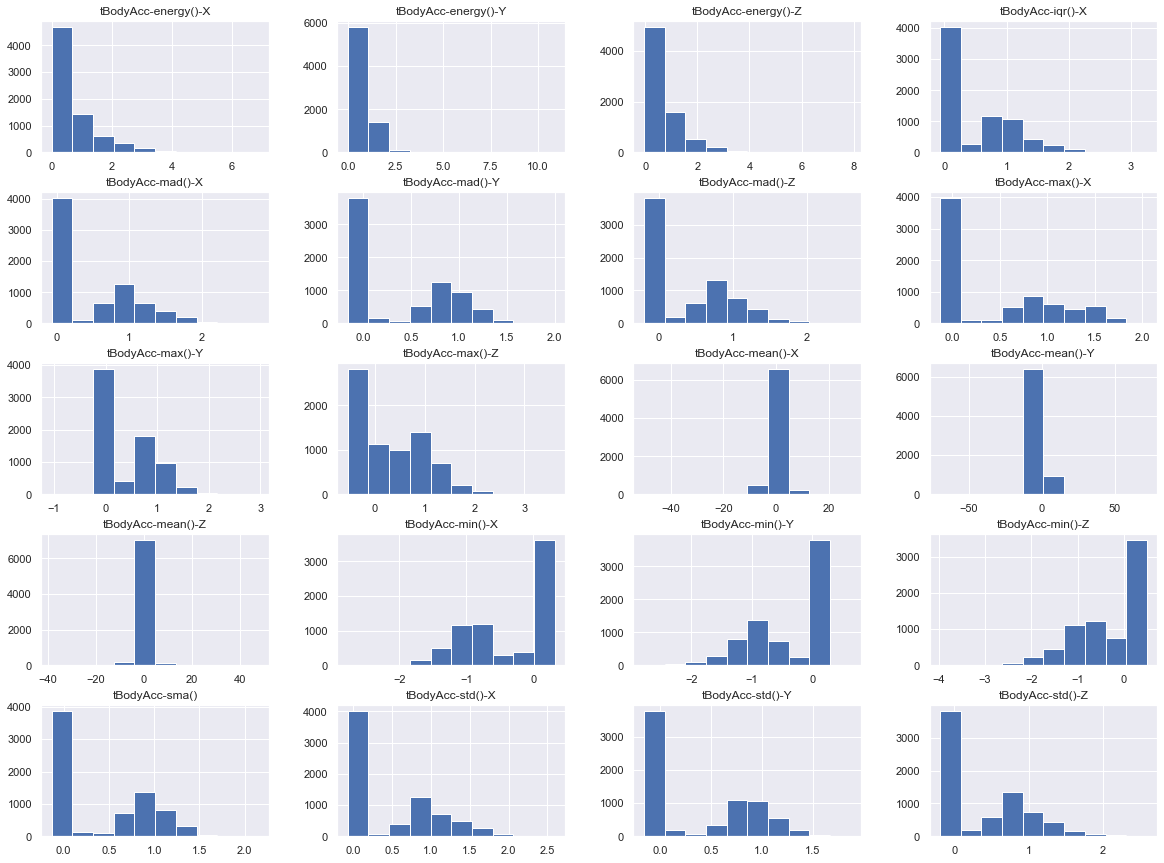

In [17]:
X_train_r_scaled.iloc[:,:20].hist(figsize=(20,15))#make a histogram of each variable
plt.plot();

**Comment:**
- There is no difference visually in both Standard Scaling and Robust Scaling.


## 3. Linear SVM Definition and Training

### Standard Scaled Data

#### Default Parameters (Standard Scaled)

In [18]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

svm_model = OneVsRestClassifier(SVC(kernel='linear', C=1))
svm_model.fit(X_train_s_scaled,Y_train)

Y_pred=svm_model.predict(X_test_s_scaled)

print("ACCURACY TRAIN SET (LIB)",svm_model.score(X_train_s_scaled,Y_train))
print("ACCURACY TEST SET (LIB)",svm_model.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test,Y_pred))

ACCURACY TRAIN SET (LIB) 0.9970076169749728
ACCURACY TEST SET (LIB) 0.9602986087546658

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       537
           SITTING       0.97      0.86      0.91       491
          STANDING       0.90      0.98      0.93       532
           WALKING       0.95      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.96      0.97       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



#### Best Parameters (Standard Scaled)

In [19]:
from sklearn.model_selection import GridSearchCV

svm_model = OneVsRestClassifier(SVC(kernel='linear'))
parameters = {'estimator__kernel':['linear'], 'estimator__C': np.logspace(-3, 3, num=7, endpoint=True, base=10.0)}

s_grid = GridSearchCV(svm_model, param_grid = parameters ,return_train_score=True)
s_grid.fit(X_train_s_scaled, Y_train)

s_linear_best_params = s_grid.best_params_

print(s_linear_best_params)

{'estimator__C': 0.1, 'estimator__kernel': 'linear'}


#### Effect of Regularization Parameter C (Standard Scaled)

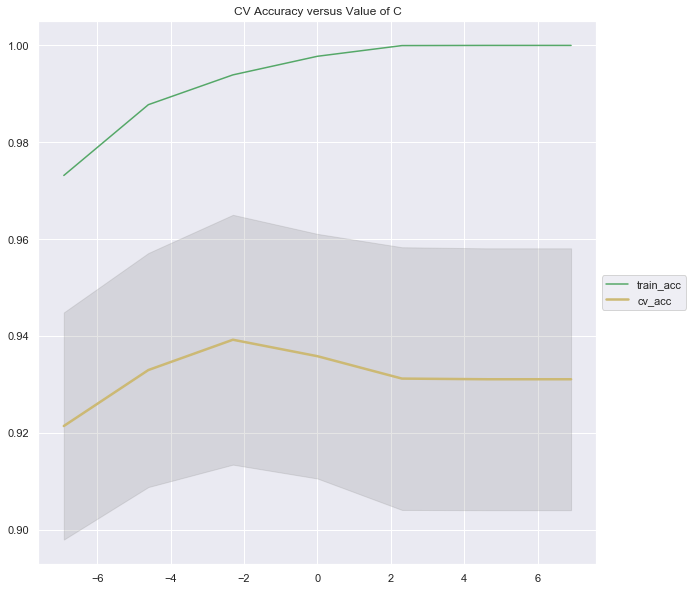

In [20]:
C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),
        s_grid.cv_results_['mean_train_score'],
        color='g',
        lw=1.5,
        label='train_acc')
ax.plot(np.log(C_values),s_grid.cv_results_['mean_test_score'],color='y',lw=2.5,label='cv_acc')
plt.fill_between(np.log(C_values), 
                 s_grid.cv_results_['mean_test_score']-s_grid.cv_results_['std_test_score'], 
                 s_grid.cv_results_['mean_test_score']+s_grid.cv_results_['std_test_score'],
                 color='gray', 
                 alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Performance Test (Standard Scaled)

GLOBAL ACCURACY TRAIN SET (LIB) 0.9923830250272034
GLOBAL ACCURACY TEST SET (LIB) 0.9602986087546658

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.87      0.91       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.95      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.96      0.97       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

CONFUSION MATRIX TEST SET:


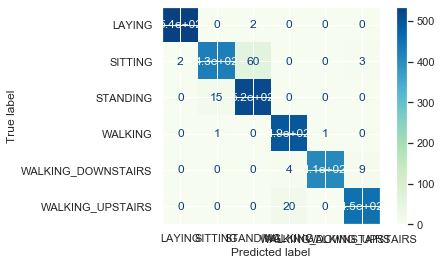

In [21]:
s_best_svm_model = OneVsRestClassifier(SVC(kernel='linear', C=s_linear_best_params['estimator__C']))
s_best_svm_model.fit(X_train_s_scaled, Y_train)

Y_pred_s_best=s_best_svm_model.predict(X_test_s_scaled)

print("GLOBAL ACCURACY TRAIN SET (LIB)",s_best_svm_model.score(X_train_s_scaled, Y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",s_best_svm_model.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, Y_pred_s_best))

cm = confusion_matrix(Y_test, Y_pred_s_best)
print("CONFUSION MATRIX TEST SET:")

plot_confusion_matrix(s_best_svm_model, X_test_s_scaled, Y_test, cmap=plt.cm.GnBu)
plt.show()

**Comment:**
- Cross-validation is necessary, because the optimization cannot be done with either the training data, which is used to fit the model or test data used for testing the optimized model.
- Another possibility would be to use a validation set, but cross validation is usually more efficient, since it completes multiple training and optimization rounds instead of only one with a validation set.

### Robust Scaled Data

#### Default Parameters (Robust Scaled)

In [22]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

svm_model = OneVsRestClassifier(SVC(kernel='linear', C=1))
svm_model.fit(X_train_r_scaled,Y_train)

Y_pred=svm_model.predict(X_test_r_scaled)

print("ACCURACY TRAIN SET (LIB)",svm_model.score(X_train_r_scaled,Y_train))
print("ACCURACY TEST SET (LIB)",svm_model.score(X_test_r_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test,Y_pred))

ACCURACY TRAIN SET (LIB) 0.9955114254624592
ACCURACY TEST SET (LIB) 0.9575839837122497

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       537
           SITTING       0.97      0.87      0.91       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.95      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



#### Best Parameters (Robust Scaled)

In [23]:
from sklearn.model_selection import GridSearchCV

svm_model = OneVsRestClassifier(SVC(kernel='linear'))
parameters = {'estimator__kernel':['linear'], 'estimator__C': np.logspace(-3, 3, num=7, endpoint=True, base=10.0)}

r_grid = GridSearchCV(svm_model, param_grid = parameters ,return_train_score=True)
r_grid.fit(X_train_r_scaled, Y_train)

r_linear_best_params = r_grid.best_params_

print(r_linear_best_params)

{'estimator__C': 0.1, 'estimator__kernel': 'linear'}


#### Effect of Regularization Parameter C (Robust Scaled)

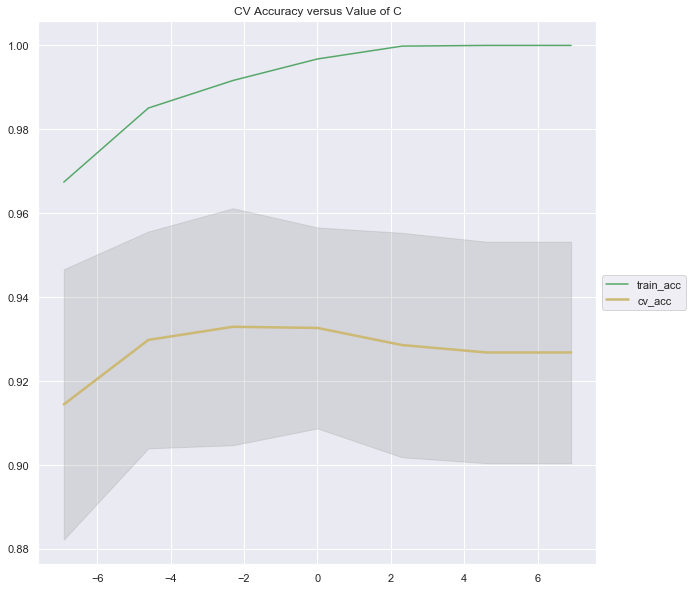

In [24]:
C_values = np.logspace(-3, 3, num=7, endpoint=True, base=10.0)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log(C_values),
        r_grid.cv_results_['mean_train_score'],
        color='g',
        lw=1.5,
        label='train_acc')
ax.plot(np.log(C_values),r_grid.cv_results_['mean_test_score'],color='y',lw=2.5,label='cv_acc')
plt.fill_between(np.log(C_values), 
                 r_grid.cv_results_['mean_test_score']-r_grid.cv_results_['std_test_score'], 
                 r_grid.cv_results_['mean_test_score']+r_grid.cv_results_['std_test_score'],
                 color='gray', 
                 alpha=0.2)
plt.title("CV Accuracy versus Value of C")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Performance Test (Robust Scaled)

GLOBAL ACCURACY TRAIN SET (LIB) 0.5724972796517954
GLOBAL ACCURACY TEST SET (LIB) 0.5690532745164574

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.87      0.91       491
          STANDING       0.89      0.96      0.92       532
           WALKING       0.94      0.99      0.96       496
WALKING_DOWNSTAIRS       0.99      0.96      0.98       420
  WALKING_UPSTAIRS       0.97      0.94      0.96       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947


CONFUSION MATRIX TEST SET:


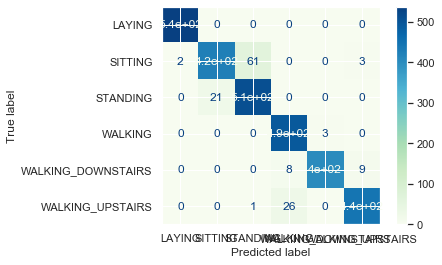

In [25]:
r_best_svm_model = OneVsRestClassifier(SVC(kernel='linear', C=r_linear_best_params['estimator__C']))
r_best_svm_model.fit(X_train_r_scaled, Y_train)

Y_pred_r_best=r_best_svm_model.predict(X_test_r_scaled)

print("GLOBAL ACCURACY TRAIN SET (LIB)",s_best_svm_model.score(X_train_r_scaled, Y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",s_best_svm_model.score(X_test_r_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, Y_pred_r_best))

cm = confusion_matrix(Y_test, Y_pred_r_best)
print("\nCONFUSION MATRIX TEST SET:")
plot_confusion_matrix(r_best_svm_model, X_test_r_scaled, Y_test, cmap=plt.cm.GnBu)
plt.show()

## 4. Non-linear SVM Definition and Training

### Standard Scaled Data

#### Default Parameters (Standard Scaled)

In [26]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

svm_model_nonlinear = OneVsRestClassifier(SVC(kernel='rbf'))
svm_model_nonlinear.fit(X_train_s_scaled,Y_train)

Y_pred_nonlinear=svm_model_nonlinear.predict(X_test_s_scaled)

print("ACCURACY TRAIN SET (LIB)",svm_model_nonlinear.score(X_train_s_scaled,Y_train))
print("ACCURACY TEST SET (LIB)",svm_model_nonlinear.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test,Y_pred_nonlinear))

ACCURACY TRAIN SET (LIB) 0.9870783460282916
ACCURACY TEST SET (LIB) 0.9521547336274178

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       0.99      0.99      0.99       537
           SITTING       0.95      0.89      0.92       491
          STANDING       0.90      0.95      0.93       532
           WALKING       0.97      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.93      0.97      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



#### Best Parameters (Standard Scaled)

In [27]:
from sklearn.model_selection import GridSearchCV

svm_model = SVC()
parameters = [
    {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['rbf']},
    {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['poly']}]

s_grid_nonlinear = GridSearchCV(svm_model, param_grid = parameters ,return_train_score=True)
s_grid_nonlinear.fit(X_train_s_scaled, Y_train)

means = s_grid_nonlinear.cv_results_['mean_test_score']
stds = s_grid_nonlinear.cv_results_['std_test_score']
params = s_grid_nonlinear.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))#param is a dict with the fields you created
    #print(param['kernel'],param['C'])#you can access the fields to see the param values

print("\nBEST RESULTS ...\n")
print("PARAMS\t:",s_grid_nonlinear.best_params_)
print("SCORE\t:",s_grid_nonlinear.best_score_)

0.759940 (0.049514) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.473748 (0.038220) with: {'C': 0.1, 'gamma': 0.02, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 0.1, 'gamma': 0.2, 'kernel': 'rbf'}
0.844676 (0.044343) with: {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.696017 (0.050697) with: {'C': 1.0, 'gamma': 0.02, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 1.0, 'gamma': 0.2, 'kernel': 'rbf'}
0.850796 (0.045191) with: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.709890 (0.049790) with: {'C': 10.0, 'gamma': 0.02, 'kernel': 'rbf'}
0.192329 (0.001228) with: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 10.0, 'gamma': 0.2, 'kernel': 'rbf'}
0.926148 (0.018515) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.926420 (0.019166) with: {'C': 0.1, 'gamma': 0.02, 'kernel': 'poly'}
0.926420 (0.019166) with: {'C': 0.

#### PerformanceTest (Standard Scaled)

GLOBAL ACCURACY TRAIN SET (LIB) 1.0
GLOBAL ACCURACY TEST SET (LIB) 0.9395995928062436

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       1.00      0.96      0.98       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.88      0.98      0.93       532
           WALKING       0.92      0.99      0.96       496
WALKING_DOWNSTAIRS       0.99      0.85      0.91       420
  WALKING_UPSTAIRS       0.90      0.95      0.92       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947

CONFUSION MATRIX TEST SET:


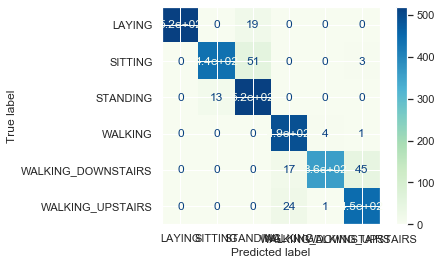

In [28]:
s_best_svm_nonlinear_model = OneVsRestClassifier(SVC( C = s_grid_nonlinear.best_params_['C'],
                                                     gamma = s_grid_nonlinear.best_params_['gamma'],
                                                     kernel = s_grid_nonlinear.best_params_['kernel']))
s_best_svm_nonlinear_model.fit(X_train_s_scaled, Y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",s_best_svm_nonlinear_model.score(X_train_s_scaled, Y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",s_best_svm_nonlinear_model.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, s_best_svm_nonlinear_model.predict(X_test_s_scaled)))

cm = confusion_matrix(Y_test, s_best_svm_nonlinear_model.predict(X_test_s_scaled))
print("CONFUSION MATRIX TEST SET:")
plot_confusion_matrix(s_best_svm_nonlinear_model, X_test_s_scaled, Y_test, cmap=plt.cm.GnBu)
plt.show()

**Comment:**
- Significance of gamma: The gamma-attribute in a Non-Linear SVM measures the magnitude of effect that single observations acting as support vectors has on the model. Gamma can intuitively be though as the inverse of the radius of the "influence" of an observation in a training set. By "influence" it means the area around the observation, where the decision-hyperplane is formed according to the object. Since the gamma value is the inverse of the radius, low values mean a big effect of an observation on the surrounding space, while a large gamma means a small effect.
- In the results (for the rbf-kernel) it seems a quite dramatic decrease of the model accuracy by increasing gamma. This is probably due to the relative sparsity of the hyperspace due to the high dimensionality, because the high gamma means a small radius of innfluence, the support vectors with small influence will not reach a big enough area of influence, so that the training examples would fall under the influence and hence are probable to be misclassified by the classification hyperplane. This effect is probably further increased by the issue being multi-class, because many of the training examples in a class probably occur relatively close to training examples of other classes.

### Robust Scaled Data

#### Default Parameters (Robust Scaled)

In [29]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

svm_model_nonlinear = OneVsRestClassifier(SVC(kernel='rbf'))
svm_model_nonlinear.fit(X_train_r_scaled,Y_train)

Y_pred_nonlinear=svm_model_nonlinear.predict(X_test_r_scaled)

print("ACCURACY TRAIN SET (LIB)",svm_model_nonlinear.score(X_train_r_scaled,Y_train))
print("ACCURACY TEST SET (LIB)",svm_model_nonlinear.score(X_test_r_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test,Y_pred_nonlinear))

ACCURACY TRAIN SET (LIB) 0.9760609357997824
ACCURACY TEST SET (LIB) 0.9436715303698676

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.89      0.90       491
          STANDING       0.90      0.93      0.92       532
           WALKING       0.94      0.97      0.95       496
WALKING_DOWNSTAIRS       0.95      0.92      0.93       420
  WALKING_UPSTAIRS       0.95      0.95      0.95       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



#### Best Parameters (Robust Scaled)

In [30]:
from sklearn.model_selection import GridSearchCV

svm_model = SVC()
parameters = [
    {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['rbf']},
    {'C': np.logspace(-1, 1, num=3, endpoint=True, base=10.0), 'gamma': [0.01, 0.02, 0.1, 0.2], 'kernel': ['poly']}]

r_grid_nonlinear = GridSearchCV(svm_model, param_grid = parameters ,return_train_score=True)
r_grid_nonlinear.fit(X_train_r_scaled, Y_train)

means = r_grid_nonlinear.cv_results_['mean_test_score']
stds = r_grid_nonlinear.cv_results_['std_test_score']
params = r_grid_nonlinear.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("\nBEST RESULTS ...\n")
print("PARAMS\t:",r_grid_nonlinear.best_params_)
print("SCORE\t:",r_grid_nonlinear.best_score_)

0.596982 (0.011089) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.489942 (0.027236) with: {'C': 0.1, 'gamma': 0.02, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 0.1, 'gamma': 0.2, 'kernel': 'rbf'}
0.756125 (0.020469) with: {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.609498 (0.014866) with: {'C': 1.0, 'gamma': 0.02, 'kernel': 'rbf'}
0.256939 (0.011760) with: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 1.0, 'gamma': 0.2, 'kernel': 'rbf'}
0.769319 (0.022400) with: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.620379 (0.013181) with: {'C': 10.0, 'gamma': 0.02, 'kernel': 'rbf'}
0.268637 (0.013294) with: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.191376 (0.000269) with: {'C': 10.0, 'gamma': 0.2, 'kernel': 'rbf'}
0.873917 (0.025982) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.898128 (0.022605) with: {'C': 0.1, 'gamma': 0.02, 'kernel': 'poly'}
0.905201 (0.022164) with: {'C': 0.

#### Performance Test (Robust Scaled)

GLOBAL ACCURACY TRAIN SET (LIB) 1.0
GLOBAL ACCURACY TEST SET (LIB) 0.9328130302002036

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       0.97      1.00      0.99       537
           SITTING       0.95      0.86      0.91       491
          STANDING       0.87      0.96      0.92       532
           WALKING       0.91      0.98      0.94       496
WALKING_DOWNSTAIRS       0.98      0.86      0.91       420
  WALKING_UPSTAIRS       0.93      0.92      0.93       471

          accuracy                           0.93      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.93      0.93      2947


CONFUSION MATRIX TEST SET:


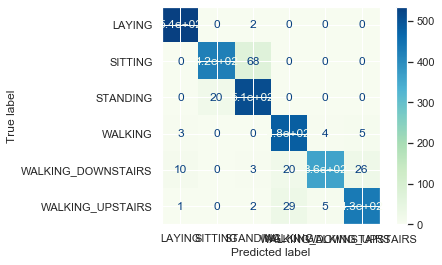

In [31]:
r_best_svm_nonlinear_model = OneVsRestClassifier(SVC( C = r_grid_nonlinear.best_params_['C'],
                                                     gamma = r_grid_nonlinear.best_params_['gamma'],
                                                     kernel = r_grid_nonlinear.best_params_['kernel']))
r_best_svm_nonlinear_model.fit(X_train_r_scaled, Y_train)

print("GLOBAL ACCURACY TRAIN SET (LIB)",r_best_svm_nonlinear_model.score(X_train_r_scaled, Y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",r_best_svm_nonlinear_model.score(X_test_r_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, r_best_svm_nonlinear_model.predict(X_test_r_scaled)))

cm = confusion_matrix(Y_test, r_best_svm_nonlinear_model.predict(X_test_r_scaled))
print("\nCONFUSION MATRIX TEST SET:")
plot_confusion_matrix(r_best_svm_nonlinear_model, X_test_r_scaled, Y_test, cmap=plt.cm.GnBu)

## 5. Examining Linear Model

### Class Comparison Based On Coefficients to Dataset
(n_classes * (n_classes - 1)) / (n_classes -2 ) columns

In [32]:
class_comparison = {'LAYING-SITTING': 1, 'LAYING-STANDING' : 2, 'LAYING-WALKING' : 3, 'LAYING-WALKING_DOWNSTARS' : 4,
                   'LAYING-WALKING-UPSTAIRS' : 5, 'SITTING-STANDING' : 6, 'SITTING-WALKING' : 7, 'SITTING-WALKING_DOWNSTARS' : 8,
                   'SITTING-WALKING_UPSTAIRS' : 9, 'STANDING-WALKING' : 10, 'STANDING-WALKING_DOWNSTAIRS' : 11, 'STANDING-WALKING_UPSTAIRS' : 12,
                   'WALKING-WALKING_DOWNSTAIRS' : 13, 'WALKING-WALKING_UPSTAIRS' : 14, 'WALKING_DOWNSTAIRS-WALKING_UPSTAIRS' : 15}

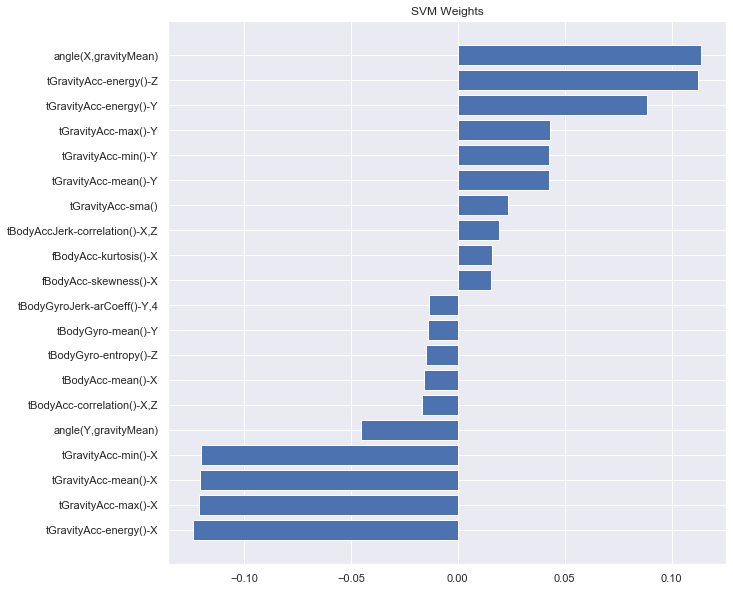

In [33]:
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_s_scaled,Y_train)

w = svm_model.coef_
w = pd.DataFrame(w)
w.columns = X_train_s_scaled.columns
w = pd.DataFrame.transpose(w)

coefficient_N = class_comparison['LAYING-SITTING'] # Write the wanted pairing to show coefficients
coefficient_arranger = class_comparison

w_sorted = pd.DataFrame.sort_values(w, coefficient_N, ascending = False)
    
minmax = w_sorted.nlargest(10, [coefficient_N])[coefficient_N]
minmax = minmax.append(w_sorted.nsmallest(10,[coefficient_N])[coefficient_N])
minmax = minmax.sort_values()
            
fig, ax = plt.subplots(figsize=(10,10))
var_idx = range(0,len(minmax))
ax.barh(var_idx, minmax, align='center')
ax.set_yticks(var_idx)
ax.set_yticklabels(minmax.index)
plt.title("SVM Weights")
plt.show()

**Comment:**
- The SVM weights by attributes can be seen as the most important attributes to differentiate the observations between the two classes compared with class_comparison.

## 6. Support Vectors in the Linear and Non-linear Model

### Linear SVM

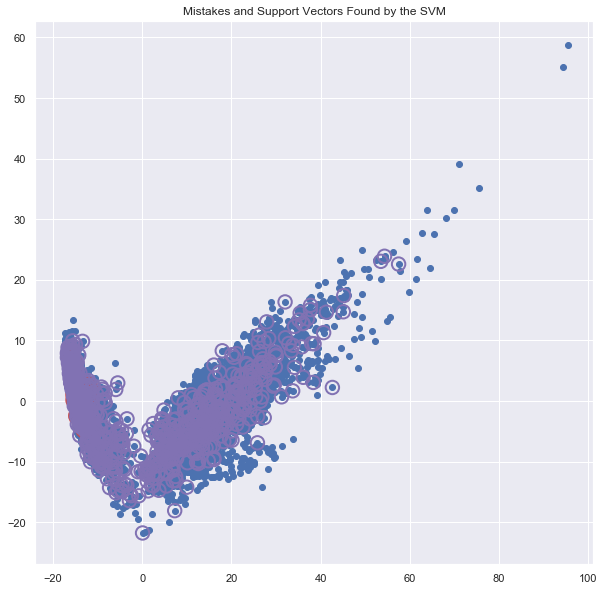

In [34]:
from sklearn.decomposition import PCA

svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_s_scaled,Y_train)

pca = PCA(n_components=2)
pca.fit(X_train_s_scaled)
X_train_projected = pca.transform(X_train_s_scaled)
Y_train_pred = svm_model.predict(X_train_s_scaled)
train_decision = svm_model.decision_function(X_train_s_scaled)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_projected[:,0],X_train_projected[:,1],cmap = Y_train)

X_train_s_scaled2 = X_train_s_scaled.copy()
X_train_s_scaled2.insert(0, 'prediction', Y_train_pred)
X_mistakes = X_train_s_scaled2[Y_train != Y_train_pred]
X_mistakes_projected = pca.transform(X_mistakes.drop(['prediction'], axis = 1))
ax.scatter(X_mistakes_projected[:,0],X_mistakes_projected[:,1], s=280, facecolors='none',edgecolors='r',linewidth=3.5)

sv = svm_model.support_vectors_ #support vectors
n_sv = svm_model.n_support_ #number of support vectors
sv_idx = svm_model.support_ #indices of support vectors
sv_projected = pca.transform(sv)

ax.scatter(sv_projected[:,0],sv_projected[:,1], s=180, facecolors='none',edgecolors='m',linewidth=2)
plt.title("Mistakes and Support Vectors Found by the SVM")
plt.show()

### Non-Linear SVM

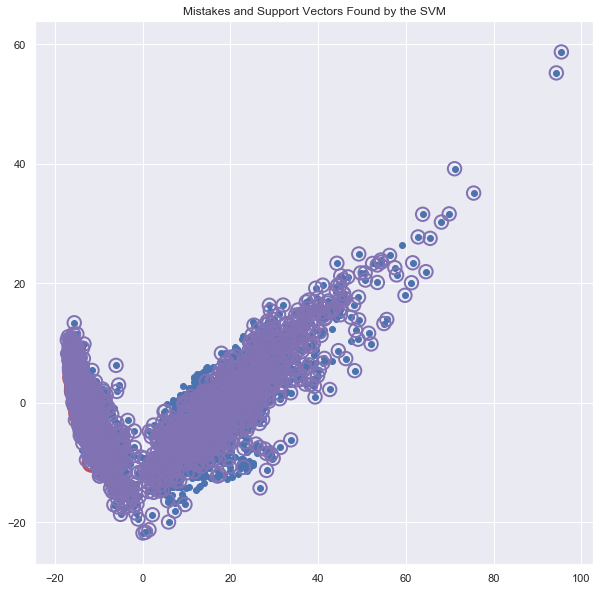

In [35]:
svm_nonlinear_model = SVC(kernel='rbf', C=1, gamma = 'scale')
svm_nonlinear_model.fit(X_train_s_scaled,Y_train)

pca = PCA(n_components=2)
pca.fit(X_train_s_scaled)
X_train_projected_nonlinear = pca.transform(X_train_s_scaled)
Y_train_pred_nonlinear = svm_nonlinear_model.predict(X_train_s_scaled)
train_decision_nonlinear = svm_nonlinear_model.decision_function(X_train_s_scaled)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_projected_nonlinear[:,0],X_train_projected_nonlinear[:,1],cmap=Y_train)

X_train_s_scaled2 = X_train_s_scaled.copy()
X_train_s_scaled2.insert(0, 'prediction', Y_train_pred_nonlinear)
X_mistakes_nonlinear = X_train_s_scaled2[Y_train != Y_train_pred_nonlinear]
X_mistakes_projected_nonlinear = pca.transform(X_mistakes_nonlinear.drop(['prediction'], axis = 1))
ax.scatter(X_mistakes_projected_nonlinear[:,0],X_mistakes_projected_nonlinear[:,1], s=280, facecolors='none',edgecolors='r',linewidth=3.5)

sv_nonlinear = svm_nonlinear_model.support_vectors_ #support vectors
n_sv_nonlinear = svm_nonlinear_model.n_support_ #number of support vectors
sv_idx_nonlinear = svm_nonlinear_model.support_ #indices of support vectors
sv_projected_nonlinear = pca.transform(sv_nonlinear)

ax.scatter(sv_projected_nonlinear[:,0],sv_projected_nonlinear[:,1], s=180, facecolors='none',edgecolors='m',linewidth=2)
plt.title("Mistakes and Support Vectors Found by the SVM")
plt.show()

### Summary

In [36]:
print('Linear SVM support vectors per class:')
print(n_sv)
print('Total number of support vectors:')
print(sum(n_sv))
print('\nNon-linear SVM support vectors per class:')
print(n_sv_nonlinear)
print('Total number of support vectors')
print(sum(n_sv_nonlinear))

Linear SVM support vectors per class:
[101 167 167 115 108 142]
Total number of support vectors:
800

Non-linear SVM support vectors per class:
[234 577 512 301 363 350]
Total number of support vectors
2337


**Comment:**
- Because Non-Linear SVM can and will adjust better to take individual observations into account. (Because the decision boundaries do not need to be linear)
- It uses more observations as support vectors. (Points to determine the boundaries by which it adjusts the decision boundaries between different classes.)
- However, the unoptimized Non-Linear SVM uses more than 1/3 of observations as support vectors, which demonstrates it proneness to overfitting.

## 7. Training For Multiple Classes

### One-vs-Rest Classifier

SVM builds a classifier for each class. Each classifier gives the probability with each observation which belongs to the class, the classifier is built to recognize observations assigned to the class with highest probability.

In [37]:
svm_ovr_model = OneVsRestClassifier(SVC(kernel='linear', C=1))
svm_ovr_model.fit(X_train_s_scaled, Y_train)
Y_pred_ovr = svm_ovr_model.predict(X_test_s_scaled)

print("OVR GLOBAL ACCURACY TRAIN SET (LIB)",svm_ovr_model.score(X_train_s_scaled, Y_train))
print("OVR GLOBAL ACCURACY TEST SET (LIB)",svm_ovr_model.score(X_test_s_scaled, Y_test))

print("DETAILED REPORT TEST SET:")
print(classification_report(Y_test, Y_pred_ovr))

OVR GLOBAL ACCURACY TRAIN SET (LIB) 0.9970076169749728
OVR GLOBAL ACCURACY TEST SET (LIB) 0.9602986087546658
DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       537
           SITTING       0.97      0.86      0.91       491
          STANDING       0.90      0.98      0.93       532
           WALKING       0.95      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.96      0.97       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



### One-vs-One Classifier

SVM builds classifiers to compare all the classes with each other (n*(n-1))/2 classifiers. Classifier receives examples from different pair of classes, the class of the pair, to which the classifier classifies the observation, receives +1 point. The "losing" class receives -1 point. The class is determined based on points by summed of points from all classifiers.

In [38]:
svm_ovo_model = SVC(kernel='linear', C=1)
svm_ovo_model.fit(X_train_s_scaled, Y_train)
Y_pred_ovo = svm_ovo_model.predict(X_test_s_scaled)

print("OVO GLOBAL ACCURACY TRAIN SET (LIB)",svm_ovo_model.score(X_train_s_scaled, Y_train))
print("OVO GLOBAL ACCURACY TEST SET (LIB)",svm_ovo_model.score(X_test_s_scaled, Y_test))

print("OVO \nDETAILED REPORT TEST SET:\n")
print(classification_report(Y_test, Y_pred_ovo))

OVO GLOBAL ACCURACY TRAIN SET (LIB) 0.9968715995647442
OVO GLOBAL ACCURACY TEST SET (LIB) 0.9565659993213438
OVO 
DETAILED REPORT TEST SET:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.86      0.91       491
          STANDING       0.89      0.96      0.92       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



**Comment:**
- Only minor variation in results between the multi-class classifiers.
- An observation with highest probability belongs to some group might be labeled to a different group based on "One-vs-One" comparison with other classes.

## 8. Evaluating The Models Beyond Accuracy

### Linear SVM

GLOBAL ACCURACY TRAIN SET (LIB) 0.9923830250272034
GLOBAL ACCURACY TEST SET (LIB) 0.9602986087546658

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.87      0.91       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.95      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.97      0.96      0.97       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947


CONFUSION MATRIX TEST SET:


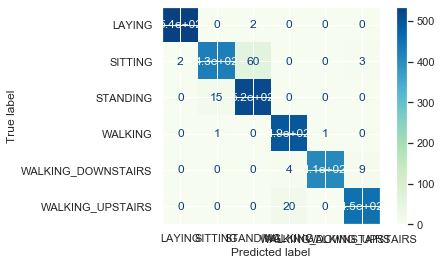

In [39]:
Y_pred_s_best = s_best_svm_model.predict(X_test_s_scaled)

print("GLOBAL ACCURACY TRAIN SET (LIB)",s_best_svm_model.score(X_train_s_scaled, Y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",s_best_svm_model.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, Y_pred_s_best))

cm = confusion_matrix(Y_test, Y_pred_s_best)
print("\nCONFUSION MATRIX TEST SET:")
plot_confusion_matrix(s_best_svm_model, X_test_s_scaled, Y_test, cmap=plt.cm.GnBu)
plt.show()

**Comments:**
- In classification report, precision part, LAYING and WALKING_DOWNSTAIRS are the easiest activities to identify as they show as 1. All the observations labeled to this class truly belong to the class. The model doesn't incorrectly label other activities to these classes.
- Recall scores (100% for LAYING, 100% for WALKING, 97% for STANDING, and 97% for WALKING_DOWNSTAIRS) are high, so observations from these classes are not generally labelled incorrectly.
- For this model, STANDING is the activity, to which most observations are labelled incorrectly: only 87% of the observations labelled to STANDING really belong to the class.
- SITTING has the lowest recall (87%), it means that 13% of observations belong to class SITTING are labelled incorrectly to another class. Considering SITTING and STANDING are both stationary activities, a hypothesis is that these two activities get mixed in the model.
- In confusion matrix, 60 observations of SITTING, the model incorrectly classifies as STANDING. Another observations from confusion matrix is that 20 observations belong to class WALKING_UPSTAIRS are incorrectly classified as WALKING.

### Non-Linear SVM

GLOBAL ACCURACY TRAIN SET (LIB) 1.0
GLOBAL ACCURACY TEST SET (LIB) 0.9395995928062436

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       1.00      0.96      0.98       537
           SITTING       0.97      0.89      0.93       491
          STANDING       0.88      0.98      0.93       532
           WALKING       0.92      0.99      0.96       496
WALKING_DOWNSTAIRS       0.99      0.85      0.91       420
  WALKING_UPSTAIRS       0.90      0.95      0.92       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947


CONFUSION MATRIX TEST SET:


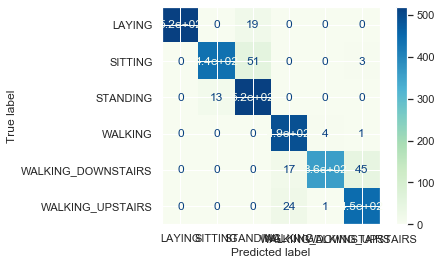

In [40]:
Y_pred_s_best_nonlinear = s_best_svm_nonlinear_model.predict(X_test_s_scaled)

print("GLOBAL ACCURACY TRAIN SET (LIB)",s_best_svm_nonlinear_model.score(X_train_s_scaled, Y_train))
print("GLOBAL ACCURACY TEST SET (LIB)",s_best_svm_nonlinear_model.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, Y_pred_s_best_nonlinear))

cm = confusion_matrix(Y_test, Y_pred_s_best_nonlinear)
print("\nCONFUSION MATRIX TEST SET:")
plot_confusion_matrix(s_best_svm_nonlinear_model, X_test_s_scaled, Y_test, cmap=plt.cm.GnBu)
plt.show()

**Comments:**
- The result for Non-Linear SVM is fairly similar to linear one, although with larger error rates. The main deviance is the decrease in recall for WALKING_DOWNSTAIRS from 97% to 85%. This means that observations from WALKING_DOWNSTAIRS are labelled to another class by the model.
- In confusion matrix, 45 observations of WALKING_DOWNSTAIRS are labelled as WALKING_UPSTAIRS. Arguably, this may be because of the tendency to overfit the model based on training data (based on the large number of support vectors), which in the test set will cause observations of WALKING_DOWNSTAIRS but being close to training labels of WALKING_UPSTAIRS falling into the wrong category.
- Labeling observations from SITTING as STANDING is a big incorrectness (51 observations) as it was in the Linear SVM.

**Definitions**
- Accuracy: Number of correctly labeled observations divided by total observations.
- Precision: Correctly to specific class labeled observations divided by total correctly and false to the class labeled predictions. (How many of the predictions to one class are correct)
- Recall: Correctly to specific class labeled observations / all observations (correctly or incorrectly labeled) belonging to the class. (what percentages of the observations of a specific class can the model label correctly)

**Comparison Comments:**
- Linear SVM is more accurate than the Non-Linear one (96.0% and 94.0%).
- The data is generally well separable with Linear model. It means that the different variables (partial vectors) of the important support vectors generally tend to fall quite linearly for different classes.
- The large number of variables (562) might cause problems to Non-Linear SVM, which has the possibility (in theory) to adjust the decision boundaries for every observations. This might result in a very complicated hyperplane for relatively well linearly separable data. (Model overfitting, which lowers the accuracy of the Non-Linear SVM.)
- Reducing the amount of variables for example by PCA, by choosing the number of variables which conserves a given treshold (for example 90% or 95%) of variability of the original dataset and run the SVM with this transformed dataset.

## 9. Dealing With Unbalanced Data

For better classifying of the most problematic classes of linear SVM, SITTING and STANDING, we can 
rebalance the data. (Increase the number of these observations in the dataset in order to increase their 
significance in the creation of the separating hyperplane)

However, in point #1 it is showed, that SITTING and STANDING are not underrepresented in the classes, in fact they have the second and the third most observations. (STANDING: 18.7 % of observations and SITTING: 17.5% of observations)

However, we can still try to oversample these classes, making their weight in the model larger. We will use a RandomOverSample to double the instances in these classes.

In [41]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

def ratio_multiplier(y):
    multiplier = {'SITTING': 2, 'STANDING': 2}
    target_stats = Counter(y)
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats

X_train_res, Y_train_res = (RandomOverSampler(sampling_strategy = ratio_multiplier).fit_resample(X_train, Y_train))

activity_count= ( Y_train_res.value_counts() / (Y_train_res.count() + 1) ) * 100

print(activity_count)

STANDING              27.444322
SITTING               25.686607
LAYING                14.051733
WALKING               12.244083
WALKING_UPSTAIRS      10.716069
WALKING_DOWNSTAIRS     9.847199
Name: Activity, dtype: float64


### Scale Rebalanced Data

In [42]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_mean = True, with_std = True)
s_scaler.fit(X_train_res)
X_train_res_scaled = s_scaler.transform(X_train_res)

### Best Parameters

In [43]:
from sklearn.model_selection import GridSearchCV

svm_ovr_model = OneVsRestClassifier(SVC(kernel='linear'))
parameters_res = {'estimator__kernel':['linear'], 'estimator__C': np.logspace(-3, 3, num=7, endpoint=True, base=10.0)}
s_grid_res = GridSearchCV(svm_ovr_model, param_grid = parameters_res ,return_train_score=True)
s_grid_res.fit(X_train_res_scaled, Y_train_res)

s_linear_res_best_params = s_grid_res.best_params_

print(s_linear_res_best_params)

{'estimator__C': 10.0, 'estimator__kernel': 'linear'}


### Performance Test

GLOBAL ACCURACY TRAIN SET (LIB) 0.9999001198561726
GLOBAL ACCURACY TEST SET (LIB) 0.9440108585001696

DETAILED REPORT TEST SET:
                    precision    recall  f1-score   support

            LAYING       0.99      0.94      0.97       537
           SITTING       0.89      0.84      0.87       491
          STANDING       0.87      0.98      0.92       532
           WALKING       0.94      1.00      0.97       496
WALKING_DOWNSTAIRS       0.99      0.99      0.99       420
  WALKING_UPSTAIRS       1.00      0.92      0.96       471

          accuracy                           0.94      2947
         macro avg       0.95      0.94      0.94      2947
      weighted avg       0.95      0.94      0.94      2947

CONFUSION MATRIX TEST SET:


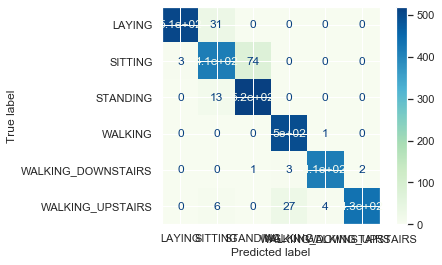

In [44]:
s_best_res_svm = OneVsRestClassifier(SVC(kernel='linear', C=s_linear_res_best_params['estimator__C']))
s_best_res_svm.fit(X_train_res_scaled, Y_train_res)
Y_pred_res = s_best_res_svm.predict(X_test_s_scaled)

print("GLOBAL ACCURACY TRAIN SET (LIB)",s_best_res_svm.score(X_train_res_scaled, Y_train_res))
print("GLOBAL ACCURACY TEST SET (LIB)",s_best_res_svm.score(X_test_s_scaled,Y_test))

print("\nDETAILED REPORT TEST SET:")
print(classification_report(Y_test, Y_pred_res))

cm = confusion_matrix(Y_test, Y_pred_res)
print("CONFUSION MATRIX TEST SET:")
plot_confusion_matrix(s_best_res_svm, X_test_s_scaled, Y_test, cmap=plt.cm.GnBu)
plt.show()

**Comments:**
- As we can see increasing the share of the hard-to-classify examples in fact lowers the accuracy of the model and the prediction accuracy of the increased classes.
- The interpretation is that, since these classes were not unrepresented in the original training sample, the difference between STANDING and SITTING is just more difficult to classify with the current attributes, and the lower score is not a result of lack of training examples.
- Additionally, by increasing the observations of these classes, the model tends to overfit to these classes, when their share in the training set is increased, decreasing the model performance even in classifying some of the other variables.